In [1]:
import numpy as np
from scipy.integrate import quad, dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Laplace equation with Neuman boundary conditions in 2D on a square domain using the finite element method. 

The Laplace equation is given by: 

$\nabla^2 u = 0$ on $\Omega$

where $\Omega$ is the domain of interest.

and the Neuman boundary conditions are given by:

$\nabla u \cdot \hat{n} = g(x,y)$ on $\partial \Omega$

where $\partial \Omega$ is the boundary of the domain and were $n$ is the outward normal vector to the boundary.

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Laplace equation is given by:

$\int_{\Omega} \nabla^2 u v d\Omega = 0$

where $v$ is a test function.

After applying Green's first identity, we get:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot n v d\partial \Omega = 0$

To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v) = u$

$\phi_2(u,v) = v$

$\phi_3(u,v) = 1-u-v$

Where $u$, $v$, and $w=1-u-v$ are the barycentric coordinates of a point in the element.

In [2]:
def basis_fn_1(u, v): return u
def basis_fn_2(u, v): return v
def basis_fn_3(u, v): return 1 - u - v

grad_basis_fn_1 = np.array([1, 0])
grad_basis_fn_2 = np.array([0, 1])
grad_basis_fn_3 = np.array([-1, -1])

basis_fn_lst = [basis_fn_1, basis_fn_2, basis_fn_3]
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3]
n_local_basis_fn = len(basis_fn_lst)

In [3]:
#Load the square triangulated mesh
mesh = tm.load_mesh('unstructured_square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

#Remove the z coordinate
mesh.vertices = mesh.vertices[:, :2]

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)

#Create a unique idx for each edge and relate it to the position of the edge in the mesh.edges_unique array.
mesh.unique_idx_to_edge_idx = {
    tuple(sorted(v)): i for i, v in enumerate(mesh.edges_unique)
}

n_vertices = len(mesh.vertices)
n_faces = len(mesh.faces)
n_edges = len(mesh.edges_unique)
n_boundary_vertices = len(mesh.boundary_vertices_idx)

# For each edge we want to know the two faces that share the edge
edge_face_ar = np.zeros((n_edges, 2), dtype=np.int32)
edge_face_ar.fill(-1)

for face_id, face in enumerate(mesh.faces):

    e1_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[0, 1]]))]
    e2_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[1, 2]]))]
    e3_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[2, 0]]))]


    if edge_face_ar[e1_idx, 0] == -1:
        edge_face_ar[e1_idx, 0] = face_id
    else:
        edge_face_ar[e1_idx, 1] = face_id

    if edge_face_ar[e2_idx, 0] == -1:
        edge_face_ar[e2_idx, 0] = face_id
    else:
        edge_face_ar[e2_idx, 1] = face_id

    if edge_face_ar[e3_idx, 0] == -1:
        edge_face_ar[e3_idx, 0] = face_id
    else:
        edge_face_ar[e3_idx, 1] = face_id

In [ ]:
# For each triangle in the mesh we need to compute the Jacobian of the map from global to local coordinates
p1_ar = mesh.vertices[mesh.faces[:, 0]]
p2_ar = mesh.vertices[mesh.faces[:, 1]]
p3_ar = mesh.vertices[mesh.faces[:, 2]] 

p3_to_p1_ar = p1_ar - p3_ar
p3_to_p2_ar = p2_ar - p3_ar

jacobian_ar = np.zeros((n_faces, 2, 2))
jacobian_ar[:, 0, 0] = p3_to_p1_ar[:, 0]
jacobian_ar[:, 0, 1] = p3_to_p1_ar[:, 1]
jacobian_ar[:, 1, 0] = p3_to_p2_ar[:, 0]
jacobian_ar[:, 1, 1] = p3_to_p2_ar[:, 1] 

#Compute the determinant of the Jacobian
det_jacobian_ar = jacobian_ar[:, 0, 0] * jacobian_ar[:, 1, 1] - jacobian_ar[:, 0, 1] * jacobian_ar[:, 1, 0]

#Compute the inverse of the Jacobian
inv_jacobian_ar = np.zeros((n_faces, 2, 2))
inv_jacobian_ar[:, 0, 0] =  jacobian_ar[:, 1, 1]
inv_jacobian_ar[:, 0, 1] = -jacobian_ar[:, 0, 1]
inv_jacobian_ar[:, 1, 0] = -jacobian_ar[:, 1, 0]
inv_jacobian_ar[:, 1, 1] =  jacobian_ar[:, 0, 0]
inv_jacobian_ar /= det_jacobian_ar[:, np.newaxis, np.newaxis]

#This list stores the product of the gradient of the basis functions with the inverse of the Jacobian
grad_basis_fn_inv_jacobian_lst = [np.dot(inv_jacobian_ar, grad_basis_fn_lst[i]) for i in range(n_local_basis_fn)]

#Now we compute the local stiffness matrix for each triangle
local_stiffness_matrix_ar = np.zeros((n_faces, n_local_basis_fn, n_local_basis_fn))

for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
        local_stiffness_matrix_ar[:, i, j] = 0.5 * det_jacobian_ar * np.sum(grad_basis_fn_inv_jacobian_lst[i] * grad_basis_fn_inv_jacobian_lst[j], axis = 1)
        local_stiffness_matrix_ar[:, j, i] = local_stiffness_matrix_ar[:, i, j]


#Now we need to assemble the global stiffness matrix
row_id = np.repeat(mesh.faces, n_local_basis_fn).flatten()
col_id = np.tile(mesh.faces, n_local_basis_fn).flatten()
data   = local_stiffness_matrix_ar.flatten()

# Create the sparse global stiffness matrix
global_stiffness_matrix = csc_matrix((data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))
global_stiffness_matrix.sum_duplicates()

In [5]:
# Apply a combination of Dirichlet and Neumann boundary conditions


# We will apply the following Dirichlet boundary conditions:

# Dirichlet BC along the left and right boundaries:
#   u(0, y) = sin(0 ) cosh(pi y) = 0
#   u(1, y) = sin(pi) cosh(pi y) = 0

# Neumann BC along the bottom and top boundaries:
#   du/dn(x, 0) = pi sin(pi x) sinh(0) = 0 -> Nothing to do for this one
#   du/dn(x, 1) = pi sin(pi x) sinh(pi) 


#This is the vector on the right hand side of our linear system of equations
rhs_vec = np.zeros(global_stiffness_matrix.shape[0])

def get_face_local_coordinates(face, node_index):

    #Get the position in local coordniates of a node in a face
    if face[0] == node_index:
        return np.array([1, 0])
    elif face[1] == node_index:
        return np.array([0, 1])
    elif face[2] == node_index:
        return np.array([0, 0])
    else:
        raise ValueError("The node is not part of the face")


# This function computes the product of a basis function and the derivative of the solution along the boundary
def basis_and_boundary_derivative_product(t, v1_local_pos, v2_local_pos, v1_global_pos, v2_global_pos, basis_fn):
    # t goes from 0 to 1 and defines the local position along the edge in term of local coordinates (u,v)
    # The function defined at the boundary is given in global coordinates, therefore we need to compute the global value of x
    # x is given by x = (n1 - n3)u + (n2 - n3)v + n3

    # We start by transforming the parameter t in local coordinates (u,v)
    (u,v) = (v2_local_pos - v1_local_pos) * t + v1_local_pos

    # Now we transform the local coordinates (u,v) into global coordinates (x,y)
    (x, y) = (v2_global_pos - v1_global_pos) * t + v1_global_pos

    return basis_fn(u, v) * (np.pi * np.sin(np.pi * x) * np.sinh(np.pi)) 

# Store in this list the indices of the nodes that are located on the boundary at x=0 and x=1
dirchlet_boundary_nodes_idx = []


# We start by enforcing the Neuman boundary conditions
# Loop over the edges that are located at the boundary of the mesh
for boundary_edge_idx in np.argwhere(edge_face_ar[:, 1] == -1):

    #Get the face to which the edge belongs
    boundary_face_idx = edge_face_ar[boundary_edge_idx, 0]
    boundary_face_node_idx = mesh.faces[boundary_face_idx][0]

    #Get the indices of the two vertices that define the edge
    v1_idx, v2_idx = mesh.edges_unique[boundary_edge_idx][0]

    #The position of the vertices in the global coordinate system
    v1_global_pos, v2_global_pos = mesh.vertices[v1_idx], mesh.vertices[v2_idx]

    #The position of the vertices in the face local coordinate system
    v1_local_pos = get_face_local_coordinates(boundary_face_node_idx, v1_idx)
    v2_local_pos = get_face_local_coordinates(boundary_face_node_idx, v2_idx)
    
    #If the edge is oriented along the x-axis and located at the top boundary
    if (v1_global_pos[1] == v2_global_pos[1]) and (np.abs(v1_global_pos[1] -1.0) <= 0.1): 

        #Integrate the product of the basis function and the derivative of the solution along the boundary
        boundary_term_ar = np.array([
            quad(basis_and_boundary_derivative_product, 0, 1, args=(v1_local_pos, v2_local_pos, v1_global_pos, v2_global_pos, basis_fn))[0] for basis_fn in basis_fn_lst 
        ]) * np.linalg.norm(v2_global_pos - v1_global_pos)



        #The boundary term is added to the right hand side vector
        for i, global_node_idx in enumerate(boundary_face_node_idx):
            rhs_vec[global_node_idx] = rhs_vec[global_node_idx] + boundary_term_ar[i]

    # If the edge is oriented along the y axis
    elif (v1_global_pos[0] == v2_global_pos[0]): 
        dirchlet_boundary_nodes_idx.append(v1_idx)
        dirchlet_boundary_nodes_idx.append(v2_idx)


# Now we enforce the Dirichlet boundary conditions
# Since the Dirichlet boundary conditions are homogeneous, we can simply remove the rows and columns that correspond to the Dirichlet boundary nodes
dirichlet_boundary_node_mask = np.zeros(n_vertices, dtype=bool)
dirichlet_boundary_node_mask[dirchlet_boundary_nodes_idx] = True


# We remove all the rows and columns that correspond to the Dirichlet boundary nodes from the stiffness matrix and the right hand side vector
global_stiffness_matrix_with_BC = global_stiffness_matrix[:, ~dirichlet_boundary_node_mask]  
global_stiffness_matrix_with_BC = global_stiffness_matrix_with_BC[ ~dirichlet_boundary_node_mask,:]     
rhs_vec_with_BC = rhs_vec[~dirichlet_boundary_node_mask]



[]

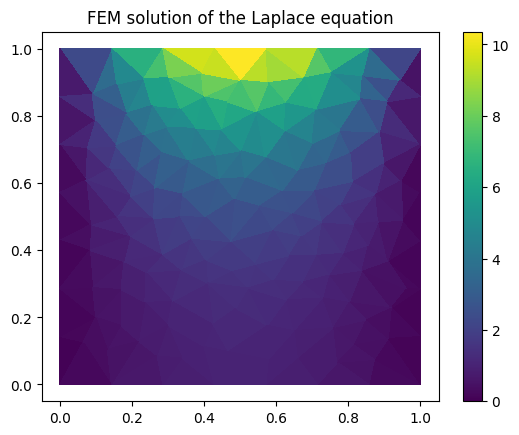

In [6]:
# Now we just have to solve the system of equations, to get the coefficients of the basis functions at the interior points
sol_interior = spsolve(global_stiffness_matrix_with_BC, rhs_vec_with_BC)

# We regroup the solution of the interior points with the boundary points
sol = np.zeros(n_vertices)

sol[~dirichlet_boundary_node_mask] = sol_interior

#Plot the solution
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat', vmin=0)
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()


[]

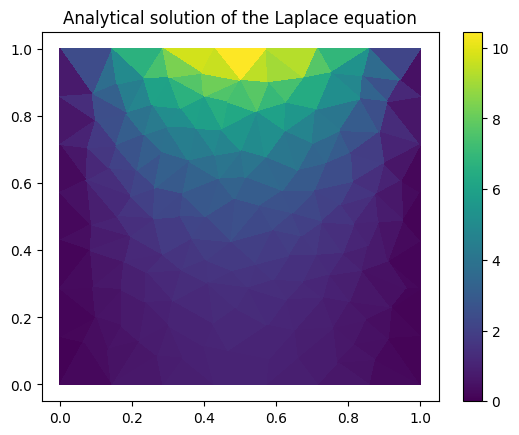

In [7]:
analytical_solution = np.sin(mesh.vertices[:, 0] * np.pi) * np.cosh(mesh.vertices[:, 1] * np.pi) 


plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

[]

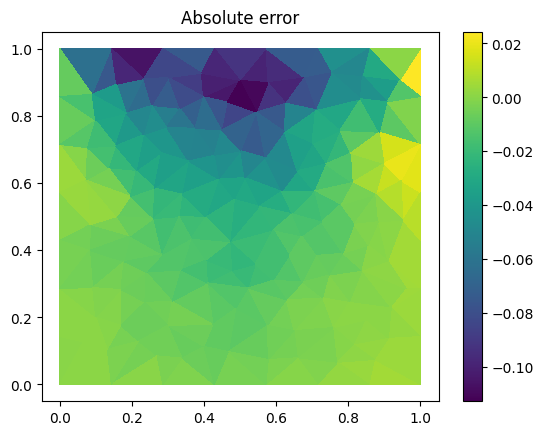

In [8]:
#Compute the relative error
absolute_error = (sol - analytical_solution.flatten()) 

plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, absolute_error, shading='flat')
plt.colorbar()
plt.title('Absolute error')
plt.plot()